In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json, glob, os, math

Using summary: results/final_summary.json


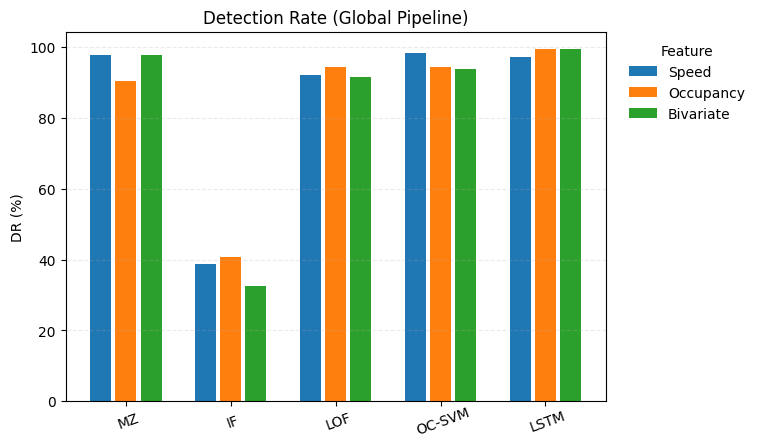

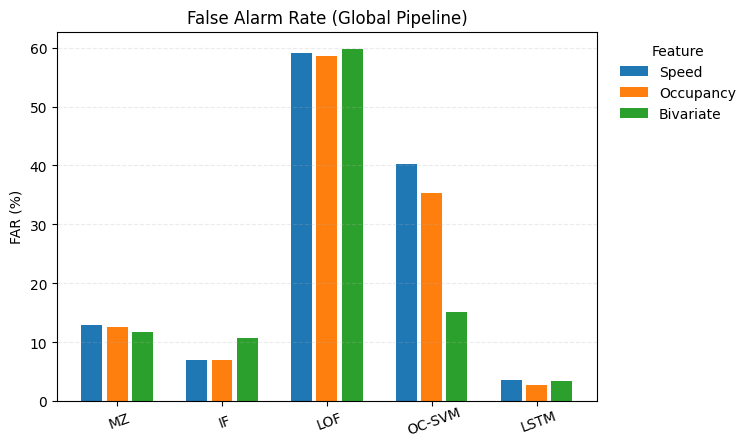

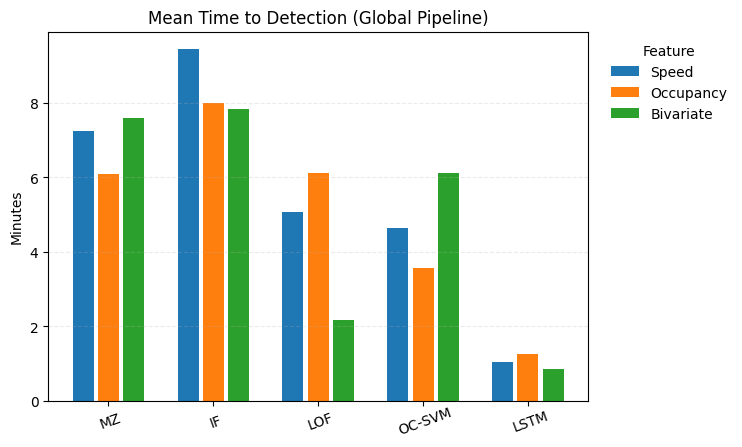

Using summary: results/final_summary.json


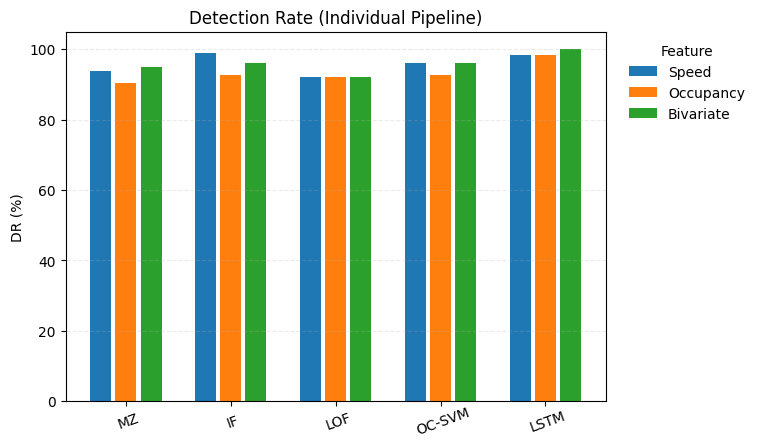

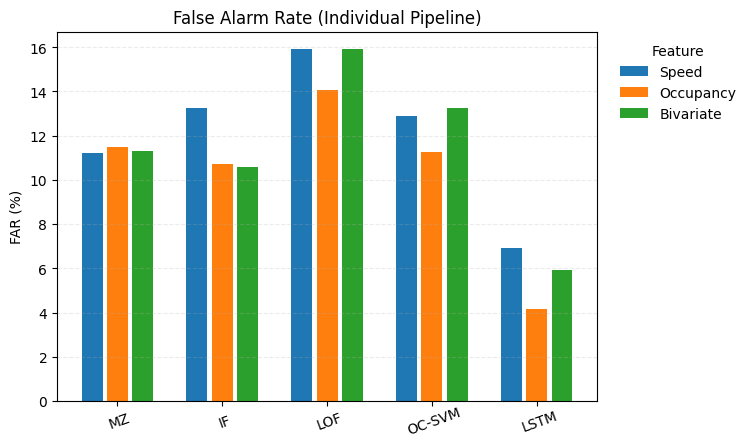

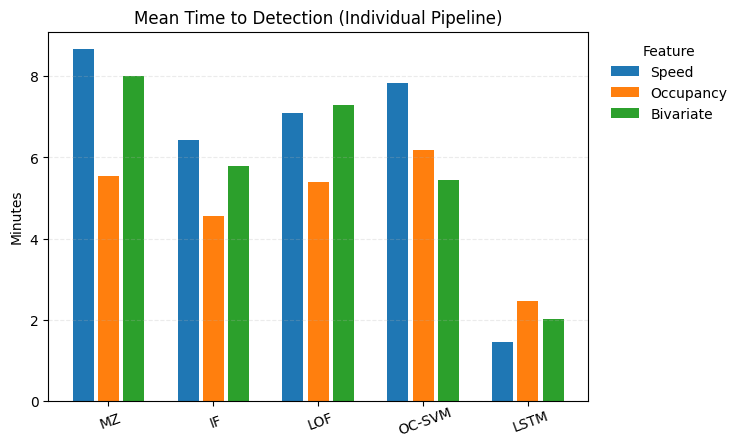

: 

In [ ]:
for pipeline_type in ("global", "individual"):

    candidates = sorted(glob.glob("results/final_summary.json"), key=os.path.getmtime)
    if not candidates:
        raise FileNotFoundError("final_summary.json not found under results/")
    summary_path = candidates[-1]
    print("Using summary:", summary_path)

    with open(summary_path, "r") as f:
        summary = json.load(f)

    models_block = summary.get(pipeline_type)
    if models_block is None:
        raise KeyError(f"No '{pipeline_type}' block found in final_summary.json")

    # Renaming map for display-only labels
    rename_map = {
        "IsolationForest": "IF",
        "OneClassSVM": "OC-SVM",
        "ModZScore": "MZ",
    }

    def disp_name(model_key: str) -> str:
        return rename_map.get(model_key, model_key)

    def to_float(x):
        if x is None:
            return None
        try:
            return float(x)
        except Exception:
            return None

    metrics = {}
    for model_key, feats in models_block.items():
        # Exclude Autoencoder entirely
        if model_key.startswith("Autoencoder"):
            continue
        model_label = disp_name(model_key)
        metrics[model_label] = {}
        for feature, vals in feats.items():
            DR   = to_float(vals.get("mean_dr"))
            FAR  = to_float(vals.get("mean_far"))
            MTTD = to_float(vals.get("mean_mttd_hours"))
            TR   = to_float(vals.get("mean_train_time_seconds"))
            PR   = to_float(vals.get("mean_predict_time_seconds"))
            TU   = to_float(vals.get("mean_tuning_time_seconds"))
            metrics[model_label][feature] = (DR, FAR, MTTD, TR, PR, TU)

    metric_names = ["DR","FAR","MTTD (h)","Avg Train (s)","Avg Predict (s)","Tuning (s)"]

    import numpy as np

    # Fixed feature colors (edit if you have different features)
    feature_colors = {
        "Speed": "#1f77b4",      # blue
        "Occupancy": "#ff7f0e",  # orange
        "Bivariate": "#2ca02c",  # green
    }

    # Customize model order here
    preferred_models = ["MZ", "IF", "LOF", "OC-SVM", "LSTM"]  # display names after rename_map
    models_order = [m for m in preferred_models if m in metrics] + [m for m in metrics.keys() if m not in preferred_models]

    # Customize feature order here
    feature_order = [f for f in ("Speed","Occupancy","Bivariate") if any(f in feats for feats in metrics.values())]

    def plot_grouped(metric_index, title=None, ylabel=None, as_percent=False, log=False, save_dir=None):
        import numpy as np
        import matplotlib.pyplot as plt

        x = np.arange(len(models_order), dtype=float)
        k = len(feature_order)
        if k == 0 or len(models_order) == 0:
            print("Nothing to plot.")
            return

        width = min(0.2, 0.7 / max(k,1))  # bar width
        offsets = np.linspace(-(k-1)/2, (k-1)/2, k) * (width*1.2)

        # Make room for an external legend on the right
        fig_w = max(8, 1.6 * len(models_order))
        fig, ax = plt.subplots(figsize=(fig_w, 4.8))

        for i, feat in enumerate(feature_order):
            vals = []
            for model in models_order:
                v = metrics.get(model, {}).get(feat, (None,)*6)[metric_index]
                vals.append(v)

            # DR/FAR → percentage values when requested
            if as_percent:
                vals = [None if v is None else v*100.0 for v in vals]

            # 2) Convert MTTD from hours to minutes before plotting
            if metric_index == 2:
                vals = [None if v is None else v*60.0 for v in vals]

            vals = np.array([np.nan if v is None else v for v in vals], dtype=float)
            ax.bar(x + offsets[i], vals, width=width, color=feature_colors.get(feat, "#666666"), label=feat)

        # Labels/titles
        ax.set_xticks(x)
        ax.set_xticklabels(models_order, rotation=20, ha='center', rotation_mode='anchor')
        ax.tick_params(axis='x', pad=6)  # optional: add a bit of space
        t = title or ""
        if log:
            ax.set_yscale('log')
            t += " (log scale)"
        ax.set_title(t)
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.grid(axis='y', alpha=0.25, linestyle='--')

        # 1) Legend outside, top-right, never overlapping bars
        leg = ax.legend(title="Feature", loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=False)
        plt.subplots_adjust(right=0.80)  # leave space on the right for the legend

        # Save if requested
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            tag = "log" if log else "lin"
            safe_title = (title or f"metric_{metric_index}").lower().replace(" ", "_").replace("(", "").replace(")", "")
            out_pdf = Path(save_dir) / f"{safe_title}_{tag}.pdf"
            fig.savefig(out_pdf, dpi=300, bbox_inches='tight')

        plt.show()

    base_vis_dir = Path("visualizations")
    out_dir_root = base_vis_dir / f"{pipeline_type}_pipeline_results"
    out_dir_root.mkdir(parents=True, exist_ok=True)
    save_dir = out_dir_root

    pipeline_title = "Global Pipeline" if pipeline_type == "global" else "Individual Pipeline"
    suffix = f" ({pipeline_title})"
    plot_grouped(metric_index=0, title=f"Detection Rate{suffix}", ylabel="DR (%)", as_percent=True, log=False, save_dir=save_dir)
    plot_grouped(metric_index=1, title=f"False Alarm Rate{suffix}", ylabel="FAR (%)", as_percent=True, log=False, save_dir=save_dir)
    plot_grouped(metric_index=2, title=f"Mean Time to Detection{suffix}", ylabel="Minutes", as_percent=False, log=False, save_dir=save_dir)
    # Tuning (s): linear and log
    # plot_grouped(metric_index=5, title="Tuning Time{suffix}", ylabel="Seconds", as_percent=False, log=False, save_dir=save_dir)
    # plot_grouped(metric_index=5, title="Tuning Time{suffix}", ylabel="Seconds", as_percent=False, log=True,  save_dir=save_dir)

#### Specific Detections, e.g. LOF

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from src.models.lof import LOFDetector
from src.models.lstm import LSTMDetector
from src.config import FEATURE_SETS

def plot_detection(STREAM, model, FEATURE_SET="Speed", TRAIN_LEN=2880, tau=1.0, zoom_start=2800):
    df = pd.read_csv(STREAM)
    y_true = df["is_incident"].values
    X = df[FEATURE_SETS[FEATURE_SET]].values

    # Parse timestamps once and format as HH:MM for labeling
    ts = pd.to_datetime(df["timestamp"], errors="coerce")
    hhmm = ts.dt.strftime("%H:%M").to_numpy()

    X_train = X[:TRAIN_LEN]
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train).astype(np.float32)
    X_full_s  = scaler.transform(X).astype(np.float32)

    if isinstance(model, LOFDetector):
        modelName = "LOF"
    model.fit(X_train_s)
    scores = model.decision_function(X_full_s)
    pred = (scores > tau).astype(int)

    def spans(mask):
        mask = mask.astype(int)
        d = np.diff(np.r_[0,mask,0])
        starts = np.where(d==1)[0]
        ends   = np.where(d==-1)[0]
        return list(zip(starts, ends))

    # Helper: set readable HH:MM ticks (avoid overcrowding)
    def set_time_ticks(ax, x_positions, labels, max_ticks=12):
        n = len(x_positions)
        step = max(1, n // max_ticks)
        ax.set_xticks(x_positions[::step])
        ax.set_xticklabels(labels[::step], rotation=45, ha="center")

    # 1) Full series
    t = np.arange(len(df))
    plt.figure(figsize=(12,4))
    plt.plot(t, X[:,0], lw=1.2, label=FEATURE_SET)
    first = True
    for s,e in spans(y_true):
        plt.axvspan(s, e, color='grey', alpha=0.5, label='Incident Period' if first else None)
        first = False
    idx = np.where(pred==1)[0]
    plt.scatter(idx, X[idx,0], s=12, c='red', label='Detected Anomaly')
    ax = plt.gca()
    set_time_ticks(ax, t, hhmm)
    plt.xlabel("Time (HH:MM)")
    plt.ylabel(FEATURE_SET)
    plt.title(f"Full View for {Path(STREAM).name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Zoomed (t >= zoom_start)
    t_zoom = t[zoom_start:]
    X_zoom = X[zoom_start:]
    y_true_zoom = y_true[zoom_start:]
    pred_zoom = pred[zoom_start:]
    hhmm_zoom = hhmm[zoom_start:]

    plt.figure(figsize=(12,4))
    plt.plot(t_zoom, X_zoom[:,0], lw=1.2, label=FEATURE_SET)
    first = True
    for s, e in spans(y_true_zoom):
        plt.axvspan(t_zoom[s], t_zoom[e-1], color='darkgrey', alpha=0.5, label='Incident Period' if first else None)
        first = False
    idx_z = np.where(pred_zoom==1)[0]
    plt.scatter(t_zoom[idx_z], X_zoom[idx_z,0], s=12, c='red', label='Detected Anomaly')
    ax = plt.gca()
    set_time_ticks(ax, t_zoom, hhmm_zoom)
    plt.xlabel("Time (HH:MM)")
    plt.ylabel(FEATURE_SET)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Choose ONE stream to produce exactly two plots
for STREAM in [
    #   "data/incident_files/smoothed/incident_56.csv",
    #   "data/incident_files/smoothed/incident_78.csv",
    #   "data/incident_files/smoothed/incident_88.csv",
    #   "data/incident_files/smoothed/incident_90.csv",
      "data/incident_files/smoothed/incident_91.csv",
      "data/incident_files/smoothed/incident_102.csv",
      "data/incident_files/smoothed/incident_109.csv",
      "data/incident_files/smoothed/incident_123.csv",
      "data/incident_files/smoothed/incident_155.csv",
      "data/incident_files/smoothed/incident_173.csv",
      "data/incident_files/smoothed/incident_185.csv",
      "data/incident_files/smoothed/incident_188.csv",
      "data/incident_files/smoothed/incident_216.csv",
      "data/incident_files/smoothed/incident_224.csv",
      "data/incident_files/smoothed/incident_231.csv",
      "data/incident_files/smoothed/incident_251.csv",
      "data/incident_files/smoothed/incident_255.csv",
      "data/incident_files/smoothed/incident_259.csv",
      "data/incident_files/smoothed/incident_262.csv",
      "data/incident_files/smoothed/incident_265.csv",
      "data/incident_files/smoothed/incident_309.csv",
      "data/incident_files/smoothed/incident_317.csv",
      "data/incident_files/smoothed/incident_326.csv",
      "data/incident_files/smoothed/incident_356.csv",
      "data/incident_files/smoothed/incident_357.csv",
      "data/incident_files/smoothed/incident_371.csv",
      "data/incident_files/smoothed/incident_387.csv",
      "data/incident_files/smoothed/incident_393.csv",
      "data/incident_files/smoothed/incident_403.csv",
      "data/incident_files/smoothed/incident_405.csv",
      "data/incident_files/smoothed/incident_414.csv",
      "data/incident_files/smoothed/incident_416.csv",
      "data/incident_files/smoothed/incident_440.csv",
      "data/incident_files/smoothed/incident_441.csv",
      "data/incident_files/smoothed/incident_442.csv"]:
#    plot_detection(STREAM, model=LOFDetector(n_neighbors=75), FEATURE_SET="Occupancy", TRAIN_LEN=2880,
#               tau=1.0949526082025036, zoom_start=2800)

    plot_detection(STREAM, model=LSTMDetector(batch_size=32,
      lstm_units=32,
      n_layers=1,
      random_state=42,
      window_size=24), FEATURE_SET="Speed", TRAIN_LEN=2880,
                   tau=0.044020903884511985, zoom_start=2800)

# Compare Smoothing

In [ ]:
REPO_ROOT = Path('/home/karam-abu-judom/Sync/BME/2025_2026_1/Thesis/thesis_repo')
DATA_DIR = REPO_ROOT / 'data'
INCIDENT_DATA_DIR = DATA_DIR / 'incident_files'
SMOOTHED_DIR = INCIDENT_DATA_DIR / 'smoothed'
OUTPUT_DIR = REPO_ROOT / 'visualizations/eda'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_DAYS = 3          # number of training days visible before test
TEST_HOURS = 12         # test duration
FIGSIZE = (12, 7)       # narrower figure for paper
BASE_FONTS = {
    'figure.dpi': 150, 'axes.titlesize': 13, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
}
plt.rcParams.update(BASE_FONTS)

INCIDENT_ID = 416
CSV_PATH = SMOOTHED_DIR / f'incident_{INCIDENT_ID}.csv'

def compute_window(df, train_days=TRAIN_DAYS, test_hours=TEST_HOURS):
    # Assumes df is sorted by timestamp

    # This is where the starting timestamp for the visible window is defined:
    start = df['timestamp'].iloc[0]  # <— tweak to index-based start if desired, e.g.: df['timestamp'].iloc[2500]

    # Training length before the red "test start" line:
    test_start = start + pd.Timedelta(days=train_days)  # <— adjust TRAIN_DAYS above to widen/narrow the plot
    end = test_start + pd.Timedelta(hours=test_hours)

    df_win = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)].copy()
    return df_win, start, test_start, end

def find_incident_spans(df_win):
    # Shade contiguous True blocks of is_incident
    if 'is_incident' not in df_win.columns:
        return []
    mask = df_win['is_incident'] == 1
    if not mask.any():
        return []
    grp = (mask != mask.shift()).cumsum()
    spans = []
    for _, sub in df_win.groupby(grp):
        if sub['is_incident'].iloc[0] == 1:
            spans.append((sub['timestamp'].min(), sub['timestamp'].max()))
    return spans

def pad_limits(ymin, ymax, pad_frac=0.05):
    if pd.isna(ymin) or pd.isna(ymax):
        return (0, 1)
    if ymin == ymax:
        return (ymin - 1, ymax + 1)
    pad = (ymax - ymin) * pad_frac
    return (ymin - pad, ymax + pad)

def add_annotations(ax, test_start, spans):
    ax.axvline(test_start, color='r', linestyle='--', linewidth=2, label='Test start')
    for s, e in spans:
        ax.axvspan(s, e, color='gray', alpha=0.35)

def format_time_axis(ax):
    ax.grid(True, which='both', linestyle='--', linewidth=0.6)
    for label in ax.get_xticklabels():
        label.set_rotation(20)
        label.set_horizontalalignment('right')

def _axis_label(signal: str) -> str:
    return 'Speed (mph)' if signal == 'speed' else 'Occupancy'

def plot_signal_stacked(df_win, signal, color, sensor_id, start, test_start, end, spans, incident_id):
    """
    Create a 2x1 stacked plot for a single signal: raw (top) vs smoothed (bottom),
    sharing both x and y axes; no overlay.
    """
    raw_col = signal
    sm_col = f'{signal}_smoothed'
    ylabel = _axis_label(signal)

    # Consistent y-limits across raw and smoothed
    y_min = min(df_win[raw_col].min(), df_win[sm_col].min())
    y_max = max(df_win[raw_col].max(), df_win[sm_col].max())
    ylim = pad_limits(y_min, y_max)

    fig, axes = plt.subplots(2, 1, figsize=FIGSIZE, sharex=True, sharey=True)

    # Top: raw
    ax0 = axes[0]
    ax0.plot(df_win['timestamp'], df_win[raw_col], color=color, linewidth=1.6)
    # ax0.set_title(f'{ylabel} (Before Smoothing)')
    ax0.set_ylabel(ylabel)
    ax0.set_xlabel('Time')
    add_annotations(ax0, test_start, spans)
    format_time_axis(ax0)

    # Bottom: smoothed
    ax1 = axes[1]
    ax1.plot(df_win['timestamp'], df_win[sm_col], color=color, linewidth=1.8)
    # ax1.set_title(f'{ylabel} (After Smoothing)')
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel('Time')
    # hide x tick labels and tick marks on the bottom subplot
    ax1.tick_params(axis='x', which='both', labelbottom=False, bottom=False)
    add_annotations(ax1, test_start, spans)
    format_time_axis(ax1)

    for ax in axes:
        ax.set_xlim(start, end)
        ax.set_ylim(ylim)

    # fig.suptitle(
    #     f'Incident {incident_id} at Sensor {sensor_id}: {ylabel} (raw top, smoothed bottom)',
    #     fontsize=14,
    #     y=0.98
    # )
    fig.tight_layout(rect=[0, 0.00, 1, 0.96])

    out_path = OUTPUT_DIR / f'incident_{incident_id}_{signal}_raw_vs_smoothed.pdf'
    fig.savefig(out_path, format='pdf', dpi=200, bbox_inches='tight')
    plt.close(fig)
    return out_path

def main():
    df = pd.read_csv(CSV_PATH, parse_dates=['timestamp'])
    if df.empty:
        raise RuntimeError(f'File is empty: {CSV_PATH}')

    df = df.sort_values('timestamp')
    needed = {'timestamp', 'speed', 'speed_smoothed', 'occ', 'occ_smoothed'}
    missing = needed - set(df.columns)
    if missing:
        raise RuntimeError(f'Missing required columns in {CSV_PATH}: {missing}')

    sensor_id = df['station_id'].iloc[0] if 'station_id' in df.columns and not df['station_id'].isna().all() else 'unknown'

    df_win, start, test_start, end = compute_window(df)
    spans = find_incident_spans(df_win)

    # Produce exactly two files:
    out_speed = plot_signal_stacked(
        df_win=df_win,
        signal='speed',
        color='tab:blue',      # blue for speed
        sensor_id=sensor_id,
        start=start,
        test_start=test_start,
        end=end,
        spans=spans,
        incident_id=INCIDENT_ID
    )

    out_occ = plot_signal_stacked(
        df_win=df_win,
        signal='occ',
        color='darkorange',    # orange for occupancy
        sensor_id=sensor_id,
        start=start,
        test_start=test_start,
        end=end,
        spans=spans,
        incident_id=INCIDENT_ID
    )

    print('Saved:')
    print(f' - {out_speed}')
    print(f' - {out_occ}')

if __name__ == '__main__':
    main()